In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/25/2019 17:21:12 ELBO=-4.31082397e+02 at epoch 1
02/25/2019 17:21:12 ELBO=-4.51180695e+02 at epoch 2
02/25/2019 17:21:12 ELBO=-4.44734161e+02 at epoch 3
02/25/2019 17:21:13 ELBO=-4.31135651e+02 at epoch 4
02/25/2019 17:21:13 ELBO=-4.39138855e+02 at epoch 5
02/25/2019 17:21:13 ELBO=-4.34308472e+02 at epoch 6
02/25/2019 17:21:13 ELBO=-4.22197510e+02 at epoch 7
02/25/2019 17:21:13 ELBO=-4.40173950e+02 at epoch 8
02/25/2019 17:21:14 ELBO=-4.49143402e+02 at epoch 9
02/25/2019 17:21:14 ELBO=-4.11042328e+02 at epoch 10
02/25/2019 17:21:14 ELBO=-4.21342438e+02 at epoch 11
02/25/2019 17:21:14 ELBO=-4.06399048e+02 at epoch 12
02/25/2019 17:21:14 ELBO=-4.15928345e+02 at epoch 13
02/25/2019 17:21:15 ELBO=-4.22542664e+02 at epoch 14
02/25/2019 17:21:15 ELBO=-4.18728546e+02 at epoch 15
02/25/2019 17:21:15 ELBO=-4.09060303e+02 at epoch 16
02/25/2019 17:21:15 ELBO=-4.18061981e+02 at epoch 17
02/25/2019 17:21:15 ELBO=-4.19072113e+02 at epoch 18
02/25/2019 17:21:16 ELBO=-4.17580078e+02 at epoch 19
02

Epoch   449: reducing learning rate of group 0 to 5.0000e-02.


02/25/2019 17:22:37 ELBO=-1.37512680e+02 at epoch 452
02/25/2019 17:22:38 ELBO=-1.26166595e+02 at epoch 453
02/25/2019 17:22:38 ELBO=-1.40004166e+02 at epoch 454
02/25/2019 17:22:38 ELBO=-1.36465073e+02 at epoch 455
02/25/2019 17:22:38 ELBO=-1.43549606e+02 at epoch 456
02/25/2019 17:22:38 ELBO=-1.29866501e+02 at epoch 457
02/25/2019 17:22:38 ELBO=-1.19355560e+02 at epoch 458
02/25/2019 17:22:39 ELBO=-1.24930214e+02 at epoch 459
02/25/2019 17:22:39 ELBO=-1.15914024e+02 at epoch 460
02/25/2019 17:22:39 ELBO=-1.14311485e+02 at epoch 461
02/25/2019 17:22:39 ELBO=-9.76224518e+01 at epoch 462
02/25/2019 17:22:39 ELBO=-1.12040237e+02 at epoch 463
02/25/2019 17:22:40 ELBO=-1.17476669e+02 at epoch 464
02/25/2019 17:22:40 ELBO=-1.12019928e+02 at epoch 465
02/25/2019 17:22:40 ELBO=-1.07260269e+02 at epoch 466
02/25/2019 17:22:40 ELBO=-1.10364540e+02 at epoch 467
02/25/2019 17:22:40 ELBO=-1.08219246e+02 at epoch 468
02/25/2019 17:22:41 ELBO=-1.15772675e+02 at epoch 469
02/25/2019 17:22:41 ELBO=-1.

Epoch   802: reducing learning rate of group 0 to 2.5000e-02.


02/25/2019 17:23:46 ELBO=-1.15000511e+02 at epoch 805
02/25/2019 17:23:46 ELBO=-1.04586128e+02 at epoch 806
02/25/2019 17:23:47 ELBO=-1.01471222e+02 at epoch 807
02/25/2019 17:23:47 ELBO=-9.31507034e+01 at epoch 808
02/25/2019 17:23:47 ELBO=-1.17333008e+02 at epoch 809
02/25/2019 17:23:47 ELBO=-1.06853111e+02 at epoch 810
02/25/2019 17:23:47 ELBO=-8.97519150e+01 at epoch 811
02/25/2019 17:23:48 ELBO=-1.01347679e+02 at epoch 812
02/25/2019 17:23:48 ELBO=-1.01683838e+02 at epoch 813
02/25/2019 17:23:48 ELBO=-9.27644348e+01 at epoch 814
02/25/2019 17:23:48 ELBO=-8.86695938e+01 at epoch 815
02/25/2019 17:23:48 ELBO=-9.38255081e+01 at epoch 816
02/25/2019 17:23:49 ELBO=-9.79288254e+01 at epoch 817
02/25/2019 17:23:49 ELBO=-8.76829681e+01 at epoch 818
02/25/2019 17:23:49 ELBO=-9.99351425e+01 at epoch 819
02/25/2019 17:23:49 ELBO=-9.03475418e+01 at epoch 820
02/25/2019 17:23:49 ELBO=-1.00609528e+02 at epoch 821
02/25/2019 17:23:49 ELBO=-8.91435318e+01 at epoch 822
02/25/2019 17:23:50 ELBO=-9.

Epoch   940: reducing learning rate of group 0 to 1.2500e-02.


02/25/2019 17:24:13 ELBO=-8.24218521e+01 at epoch 943
02/25/2019 17:24:14 ELBO=-8.21263275e+01 at epoch 944
02/25/2019 17:24:14 ELBO=-7.81517029e+01 at epoch 945
02/25/2019 17:24:14 ELBO=-7.77470474e+01 at epoch 946
02/25/2019 17:24:14 ELBO=-7.28302841e+01 at epoch 947
02/25/2019 17:24:15 ELBO=-8.41185760e+01 at epoch 948
02/25/2019 17:24:15 ELBO=-9.65467606e+01 at epoch 949
02/25/2019 17:24:15 ELBO=-8.54824066e+01 at epoch 950
02/25/2019 17:24:15 ELBO=-9.65113907e+01 at epoch 951
02/25/2019 17:24:15 ELBO=-7.02627182e+01 at epoch 952
02/25/2019 17:24:16 ELBO=-9.18993530e+01 at epoch 953
02/25/2019 17:24:16 ELBO=-9.10114136e+01 at epoch 954
02/25/2019 17:24:16 ELBO=-7.62971115e+01 at epoch 955
02/25/2019 17:24:16 ELBO=-8.04949875e+01 at epoch 956
02/25/2019 17:24:16 ELBO=-5.72841911e+01 at epoch 957
02/25/2019 17:24:16 ELBO=-8.70559540e+01 at epoch 958
02/25/2019 17:24:17 ELBO=-9.82646942e+01 at epoch 959
02/25/2019 17:24:17 ELBO=-8.82835999e+01 at epoch 960
02/25/2019 17:24:17 ELBO=-7.

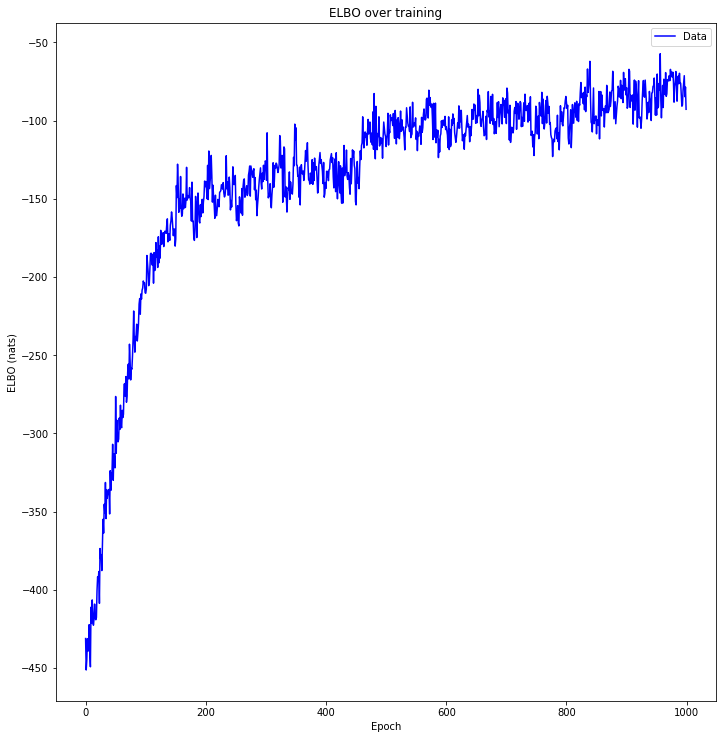

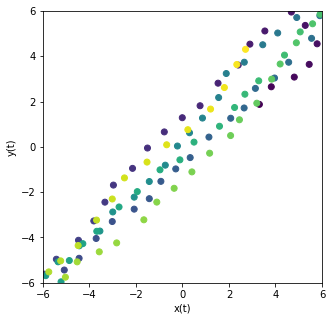

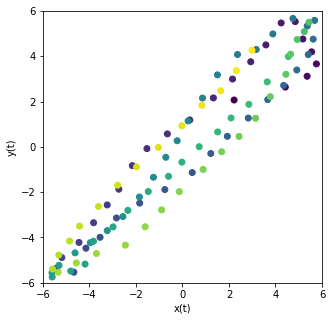

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.7555, -1.8788], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.2968, -2.6085], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.7122,  0.0000],\n        [-0.0075, -1.7612]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([2.9822, 2.1456], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.0137, -1.3712], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.3521, -2.3346], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.8637,  0.5008],\n        [ 0.6580,  0.5292],\n        [ 0.3014,  0.8053],\n        [-0.4135,  0.7535],\n        [-0.6342,  0.7147],\n        [-0.9269,  0.6692],\n        [-0.7112, -0.7517],\n        [-0.5699, -0.8150],\n        [-0.7798, -0.8514],\n        [-0.7679, -0.8009],\n        [-0.7675, -0.6538],\n        [-0.7537, -0.5943],\n        [-0.7186, -0.7321],\n        [-0.6461, -0.7787],\n        [-0.7681, -0.7925],\n        [-0.4472, -0.7770],\n        [-0.5303, -0.7836],\n  

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([3.3094, 1.8763])
Inferred position at time 0 tensor([2.2213, 2.0698])
MSE at time 0 tensor(1.2214)
Position at time 1 tensor([3.8213, 2.6541])
Inferred position at time 1 tensor([4.4230, 2.6421])
MSE at time 1 tensor(0.3622)
Position at time 2 tensor([4.8099, 3.0821])
Inferred position at time 2 tensor([5.3627, 3.1191])
MSE at time 2 tensor(0.3070)
Position at time 3 tensor([5.4516, 3.6441])
Inferred position at time 3 tensor([5.7616, 3.6642])
MSE at time 3 tensor(0.0965)
Position at time 4 tensor([5.7925, 4.5522])
Inferred position at time 4 tensor([5.5570, 4.1969])
MSE at time 4 tensor(0.1817)
Position at time 5 tensor([5.2823, 5.3643])
Inferred position at time 5 tensor([5.1798, 4.7635])
MSE at time 5 tensor(0.3714)
Position at time 6 tensor([4.6841, 5.9535])
Inferred position at time 6 tensor([4.8500, 5.5324])
MSE at time 6 tensor(0.2049)
Position at time 7 tensor([3.5442, 5.1182])
Inferred position at time 7 tensor([4.2456, 5.4727])
MSE at time 7 tensor(

In [24]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([3.0050, 1.9382])
MSE at time 0 tensor(0.0965)
Inferred position at time 1 tensor([5.1126, 3.2007])
MSE at time 1 tensor(1.9662)
Inferred position at time 2 tensor([5.5460, 3.7334])
MSE at time 2 tensor(0.9660)
Inferred position at time 3 tensor([5.5875, 4.3331])
MSE at time 3 tensor(0.4933)
Inferred position at time 4 tensor([5.6540, 5.0756])
MSE at time 4 tensor(0.2932)
Inferred position at time 5 tensor([5.2657, 5.5823])
MSE at time 5 tensor(0.0478)
Inferred position at time 6 tensor([4.7812, 5.6186])
MSE at time 6 tensor(0.1216)
Inferred position at time 7 tensor([4.0509, 5.7587])
MSE at time 7 tensor(0.6668)
Inferred position at time 8 tensor([3.2521, 4.8265])
MSE at time 8 tensor(0.2068)
Inferred position at time 9 tensor([2.6849, 4.1668])
MSE at time 9 tensor(0.3878)
Inferred position at time 10 tensor([1.7993, 3.2964])
MSE at time 10 tensor(0.3058)
Inferred position at time 11 tensor([1.2367, 2.6397])
MSE at time 11 tensor(0.9052)
Inferred pos

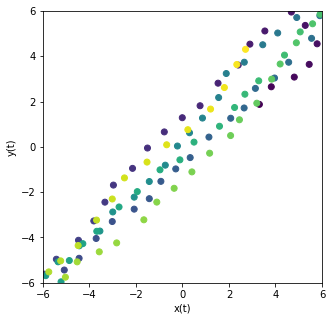

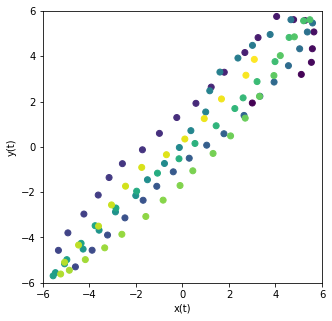

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)